In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
import cartopy.crs as ccrs
import os
#from pyproj import CRS
import geopandas as gpd
#from pykrige.ok import OrdinaryKriging
from osgeo import osr
from osgeo import gdal
from scipy.spatial import distance_matrix
#from scipy.interpolate import Rbf
import rasterio as rio
import itertools as it
from pyproj import Transformer, CRS


path_data = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data')
path_out = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results')

In [2]:
lab_chemical_properties = pd.read_csv(
    os.path.join(path_data, 'NCSSLabDataMart_MSAccess', 'lab_chemical_properties_vw.csv')
).set_index('layer_key')[['ca_nh4_ph_7', 'mg_nh4_ph_7', 'na_nh4_ph_7', 
                          'k_nh4_ph_7', 'acidity_bacl2_tea_ph_8_2', 
                          'aluminum_kcl_extractable', 'cec_nh4_ph_7']]

layer_properties = pd.read_csv(
    os.path.join(path_data, 'NCSSLabDataMart_MSAccess', 'ncss_labdata_lab_layer.csv')
)[['layer_key', 'site_key', 'hzn_top', 'hzn_bot']].set_index('layer_key')
layer_properties['hzn_node'] = layer_properties[['hzn_top', 'hzn_bot']].mean(axis = 1)
layer_properties['hzn_thickness'] = layer_properties['hzn_bot'] - layer_properties['hzn_top']
# remove invalid and negative layers
layer_properties = layer_properties.dropna(axis = 0, how = 'any')
layer_properties = layer_properties.query('hzn_top >= 0. and hzn_thickness >= 0.')
layer_properties['site_key'] = layer_properties['site_key'].astype(np.int64)

common_layers = lab_chemical_properties.index.intersection(layer_properties.index)
lab_chemical_properties = lab_chemical_properties.loc[common_layers, :]
layer_properties = layer_properties.loc[common_layers, :]

site_coords = pd.read_csv(
    os.path.join(path_data, 'NCSSLabDataMart_MSAccess', 'lab_site.csv')
)[['site_key', 'latitude_std_decimal_degrees', 
   'longitude_std_decimal_degrees']].set_index('site_key')

# remove sites without coordinates / outside the US
site_coords = site_coords.dropna(axis = 0, how = 'any')
site_coords = site_coords.query(
    'latitude_std_decimal_degrees >= 25 and latitude_std_decimal_degrees <= 50 and longitude_std_decimal_degrees >= -130 and longitude_std_decimal_degrees <= -70'
)

valid_layers = layer_properties['site_key'].isin(site_coords.index)
lab_chemical_properties = lab_chemical_properties.loc[valid_layers, :]
layer_properties = layer_properties.loc[valid_layers, :]

# add site info to the lab chemical properties
layer_to_site = layer_properties['site_key'].to_dict()
lab_chemical_properties['site_key'] = [layer_to_site[i] for i in lab_chemical_properties.index]

/tmp/ipykernel_34760/123063515.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  lab_chemical_properties = pd.read_csv(
/tmp/ipykernel_34760/123063515.py:7: DtypeWarning: Columns (9,10,11,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  layer_properties = pd.read_csv(
/tmp/ipykernel_34760/123063515.py:21: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  site_coords = pd.read_csv(


## 1. Check data availability

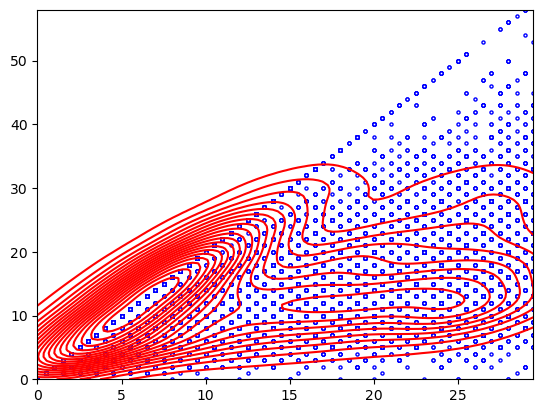

In [13]:
x = layer_properties['hzn_node'].values
y = layer_properties['hzn_thickness'].values
y = y[x < 30]
x = x[x < 30]
kde = gaussian_kde([x[::100], y[::100]])

# Creating a grid of values
xgrid = np.linspace(x.min(), x.max(), 100)
ygrid = np.linspace(y.min(), y.max(), 100)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde(np.vstack([Xgrid.ravel(), Ygrid.ravel()])).reshape(Xgrid.shape)

fig, ax = plt.subplots()
ax.scatter(x, y, s=5, facecolor='white', edgecolor='blue')
ax.contour(Xgrid, Ygrid, Z, colors='red', levels=20)
#ax.set_xlim([0, 100])
#ax.set_ylim([0, 50])
plt.show()

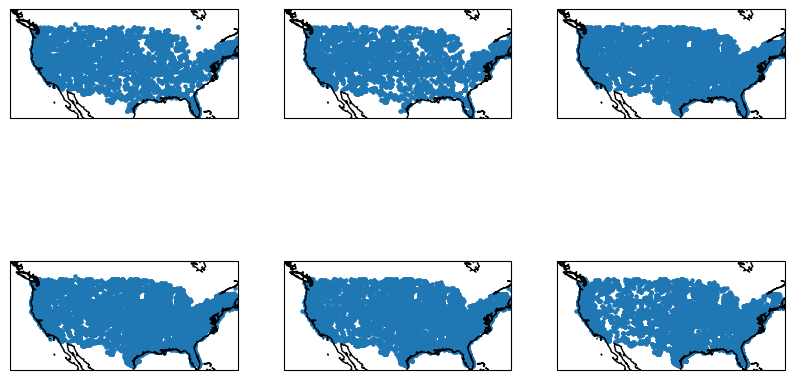

In [14]:
# convert from m to cm; Table 6.1 Soil Layer structure, CLM4.5 doc
# Merge the top 10cm into one because too few observations
# 0.0175, 0.0451, 0.0906, 
# Merge the 10-30cm into one because too few observations
# 0.1655, 0.2891, 
# Below 1.38m doesn't have much data; use relaxed criteria here then
# 1.3828, 2.2961, 3.8019, merge those layers too
elm_bot = 100 * np.array([ 0.0906, 0.2891, 0.4929, 0.8289, 1.3828, 3.8019])
elm_top = np.insert(elm_bot[:-1], 0, 0)

num_obs = pd.DataFrame(0, index = range(len(elm_bot)), 
                       columns = lab_chemical_properties.columns)

fig, axes = plt.subplots(2, 3, figsize = (10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
for i, (top, bottom) in enumerate(zip(elm_top, elm_bot)):
    if i == 0:
        top_above = -0.1
    else:
        top_above = elm_top[i-1]
    if i == len(elm_bot) - 1:
        bot_below = 4.7392
    else:
        bot_below = elm_bot[i+1]

    # layer starts one layer above, and ends in the layer
    # 0.1 allows some inaccuracies
    straddle_top = layer_properties.query('hzn_top > @top_above and hzn_top < (@top+0.1) and hzn_bot > @top and hzn_bot < @bottom')
    straddle_top = straddle_top.reset_index().set_index('site_key').sort_index()

    # layer starts in the layer, and ends one layer below
    # 0.1 allows some inaccuracies
    straddle_bot = layer_properties.query('hzn_top > @top and hzn_top < @bottom and hzn_bot > (@bottom-0.1) and hzn_bot < @bot_below')
    straddle_bot = straddle_bot.reset_index().set_index('site_key').sort_index()

    if top < 138:
        # layer must be exact match
        middle = layer_properties.query('abs(hzn_top - @top) < 0.1 and abs(hzn_bot - @bottom) < 0.1')
        middle = middle.reset_index().set_index('site_key').sort_index()
    else:
        # so long as there are some observations in the middle
        middle = layer_properties.query('hzn_top >= (@top - 0.1) and hzn_bot <= (@bottom + 0.1)')
        middle = middle.reset_index().set_index('site_key').sort_index()

    # site must have one observation that's an exact match, 
    # or have observations for both straddling layers (there
    # may be additional layers in the middle that we do not care)
    has_obs = middle.index.union(straddle_top.index.intersection(straddle_bot.index))

    # Check the number of points for individual cations
    for col in lab_chemical_properties.columns:
        site_subset = lab_chemical_properties.loc[~lab_chemical_properties[col].isna(), 'site_key'].drop_duplicates()

        num_obs.loc[i, col] = len(has_obs.intersection(list(site_subset)))

    ax = axes.flat[i]
    ax.coastlines()
    ax.set_extent([-130, -70, 25, 50])
    ax.scatter(site_coords.loc[has_obs, 'longitude_std_decimal_degrees'],
               site_coords.loc[has_obs, 'latitude_std_decimal_degrees'], s = 5)

In [15]:
num_obs

,ca_nh4_ph_7,mg_nh4_ph_7,na_nh4_ph_7,k_nh4_ph_7,acidity_bacl2_tea_ph_8_2,aluminum_kcl_extractable,cec_nh4_ph_7,site_key
0,8247,8297,8366,8402,6824,3688,7864,8656
1,7720,7768,7787,7855,6485,3688,7277,8140
2,21835,21952,21946,22158,19197,10113,19217,22765
3,20267,20373,20409,20565,17773,9646,17807,21177
4,19836,19935,19860,20084,17460,9904,17250,20609
5,12354,12401,12297,12441,10867,6640,10498,12758


## 2. Perform depth interpolation

In [ ]:
elm_bot = 100 * np.array([0.0906, 0.2891, 0.4929, 0.8289, 1.3828, 3.8019])
elm_top = np.insert(elm_bot[:-1], 0, 0)

xlswriter = pd.ExcelWriter(os.path.join(path_out, 'interp_NCSS.xlsx'), engine='openpyxl')

for i, (top, bottom) in enumerate(zip(elm_top, elm_bot)):
    if i == 0:
        top_above = -0.1
    else:
        top_above = elm_top[i-1]
    if i == len(elm_bot) - 1:
        bot_below = 4.7392
    else:
        bot_below = elm_bot[i+1]

    # layer starts one layer above, and ends in the layer
    # 0.1 allows some inaccuracies
    straddle_top = layer_properties.query('hzn_top > @top_above and hzn_top < (@top+0.1) and hzn_bot > @top and hzn_bot < @bottom')

    # layer starts in the layer, and ends one layer below
    # 0.1 allows some inaccuracies
    straddle_bot = layer_properties.query('hzn_top > @top and hzn_top < @bottom and hzn_bot > (@bottom-0.1) and hzn_bot < @bot_below')

    if top < 138:
        # layer must be exact match
        middle = layer_properties.query('abs(hzn_top - @top) < 0.1 and abs(hzn_bot - @bottom) < 0.1')
    else:
        # so long as there are some observations in the middle
        middle = layer_properties.query('hzn_top >= (@top - 0.1) and hzn_bot <= (@bottom + 0.1)')

    # site must have one observation that's an exact match, 
    # or have observations for both straddling layers
    use_exact = list(middle['site_key'].drop_duplicates())
    use_interp = set(straddle_top['site_key']) & set(straddle_bot['site_key'])
    use_interp = list(use_interp.difference(use_exact))
    interp_values = pd.DataFrame(np.nan, 
                                 index = use_exact + use_interp, 
                                 columns = lab_chemical_properties.columns[:-1])

    # (1) the case using middle values - simply average
    interp_values.loc[use_exact, :] = lab_chemical_properties.loc[middle.index, :].groupby('site_key').mean()

    # (2) the case needing interpolation - weighted average using the
    #     fraction overlapping with the layer; note in addition to straddle_top
    #     and straddle_bot, there may be other observations not covering the whole layer
    straddle_mid = layer_properties.query('hzn_top > @top and hzn_bot < @bottom')
    straddle_layers = list(
        set(straddle_top.index[straddle_top['site_key'].isin(use_interp)]) | \
        set(straddle_bot.index[straddle_bot['site_key'].isin(use_interp)]) | \
        set(straddle_mid.index[straddle_mid['site_key'].isin(use_interp)]) )

    to_interpolate = lab_chemical_properties.loc[straddle_layers, :]

    layer_thickness = layer_properties.loc[straddle_layers, 'hzn_thickness']
    overlap_thickness = \
        np.minimum(
            layer_properties.loc[straddle_layers, 'hzn_bot'].values, 
            bottom
        ) - np.maximum(
            layer_properties.loc[straddle_layers, 'hzn_top'].values, 
            top
        )
    layer_weight = overlap_thickness / layer_thickness

    for col in interp_values:
        weighted_sum = to_interpolate[col] * layer_weight
        weight_sum = ~(to_interpolate[col].isna()) * layer_weight
        temp = pd.concat([weighted_sum, weight_sum, to_interpolate['site_key']],
                         axis = 1)
        temp.columns = ['weighted_sum', 'weight_sum', 'site_key']
        temp = temp.groupby('site_key').sum()
        temp = temp['weighted_sum'] / temp['weight_sum']
        interp_values.loc[temp.index, col] = temp

    interp_values.to_excel(xlswriter, sheet_name = f'layer_{i}')
xlswriter.close()

## 3. Perform vertical interpolation

Save to geotiff

In [ ]:
def idw_interpolation(x, y, z, xi, yi, power=2):
    distances = distance_matrix(np.column_stack([x, y]), np.column_stack([xi.ravel(), yi.ravel()]))
    weights = 1.0 / distances**power
    weights /= weights.sum(axis=0)
    zi = np.dot(weights.T, z)
    return zi.reshape(xi.shape)

In [ ]:
""" Need to run this on a server to have enough memory """
elm_bot = 100 * np.array([0.0906, 0.2891, 0.4929, 0.8289, 1.3828, 3.8019])
elm_top = np.insert(elm_bot[:-1], 0, 0)

for i, (top, bottom) in enumerate(zip(elm_top, elm_bot)):
    interp_values = pd.read_excel(os.path.join(path_out, 'interp_NCSS.xlsx'), 
                                  sheet_name = f'layer_{i}', index_col = 0)
    
    for j, col in enumerate(interp_values.columns):

        values = interp_values[[col]].dropna()
        coords = site_coords.loc[values.index, :]
        gdf = pd.concat([values, coords], axis = 1)
        gdf.columns = [col, 'lat', 'lon']
        gdf = gpd.GeoDataFrame(gdf,
                               geometry=gpd.points_from_xy(gdf['lon'], gdf['lat']),
                               crs='EPSG:4326')

        # Converting lat-lon to a projected coordinate system for distance accuracy
        gdf = gdf.to_crs('EPSG:5070') # OC

        # gdf.to_file(os.path.join('..', 'results', f'interp_NCSS_layer_{i}_{col}.shp'))

        # Extract coordinates and values
        x = gdf.geometry.x.values
        y = gdf.geometry.y.values
        values = gdf[col].values.astype(np.float32)

        # Create a grid where interpolation will be performed
        grid_x = np.arange(np.around(min(x)), np.around(max(x)) + 200000, 10000)
        grid_y = np.arange(np.around(max(y)) + 100000, np.around(min(y)) - 100000, -10000)
        grid_x, grid_y = np.meshgrid(grid_x, grid_y)

        z = idw_interpolation(x, y, values, grid_x, grid_y)

        """# Perform Ordinary Kriging
        ok = OrdinaryKriging(
            x, y, values,
            variogram_model='linear',
            verbose=False,
            enable_plotting=False
        )
        z, ss = ok.execute('grid', grid_x, grid_y)"""

        # use gdal to save to geotiff
        srs = osr.SpatialReference()
        srs.ImportFromEPSG(5070)

        geotransform = (grid_x[0, 0], 10000, 0, grid_y[0, 0], 0, -10000)

        gdal_data_type = gdal.GDT_Float32

        # Create the file
        driver = gdal.GetDriverByName('GTiff')
        output_file = os.path.join(path_out, f'interp_NCSS_layer_{i}_{col}.tif')
        dataset = driver.Create(output_file, z.shape[1], z.shape[0], 1, gdal_data_type)

        # Set the geotransform and projection
        dataset.SetGeoTransform(geotransform)
        dataset.SetProjection(srs.ExportToWkt())

        # Get the raster band
        band = dataset.GetRasterBand(1)

        # Write the array to band
        band.WriteArray(z)
        band.SetNoDataValue(np.nan)  # Assuming 'nan' is your no-data value

        # Clean up
        band.FlushCache()
        dataset = None

## 4. Extract the values at the UC-Davis and Hubbard Brook sites

Requires the `gee` environment; `myCondaEnv`'s pyproj installation has problem

The units see `NCSSLabDataMart_LabMethodsCodeTechNote.pdf`, page 338

"in units of centimoles per kg of soil (cmol(+) kg−1) or milliequivalents per 100 g of soil (meq 100 g−1). The KSSL reports cmol(+) kg−1 on a <2-mm air-dry basis."

In [7]:
def latlon_to_pixel(lat, lon, affine, crs = None):
    if not crs is None:
        proj_latlon = CRS.from_epsg(4326)
        proj_dataset = CRS.from_wkt(crs)
        transformer = Transformer.from_crs(proj_latlon, proj_dataset, always_xy=True)
        x, y = transformer.transform(lon, lat)
    else:
        x, y = lon, lat
    # Create an affine transformation to convert from lat/lon to pixel coordinates
    row, col = rio.transform.rowcol(affine, x, y)

    return row, col


elm_bot = 100 * np.array([0.0906, 0.2891, 0.4929, 0.8289, 1.3828, 3.8019])
elm_top = np.insert(elm_bot[:-1], 0, 0)

coords = {
    'HBR_1': (-71.728825, 43.9556695),
    'HBR_2': (-71.728825, 43.9556695),
    'UC_Davis': (-121.781708, 38.531656)
}

values = pd.DataFrame(np.nan, 
                      index = pd.MultiIndex.from_product([['HBR_1', 'HBR_2', 'UC_Davis'], 
                                          [f'layer_{i}' for i in range(len(elm_top))]]), 
                      columns = ['ca_nh4_ph_7', 'mg_nh4_ph_7', 'na_nh4_ph_7', 'k_nh4_ph_7',
                                 'acidity_bacl2_tea_ph_8_2', 'aluminum_kcl_extractable', 
                                 'cec_nh4_ph_7'])
for i, (top, bottom) in enumerate(zip(elm_top, elm_bot)):
    interp_values = pd.read_excel(os.path.join(path_out, 'interp_NCSS.xlsx'), 
                                  sheet_name = f'layer_{i}', index_col = 0)

    for j, col in enumerate(values.columns):
        h = rio.open(os.path.join(path_out, f'interp_NCSS_layer_{i}_{col}.tif'))
        data = h.read(1, masked = True)
        for site in ['HBR_1', 'HBR_2', 'UC_Davis']:
            x, y = latlon_to_pixel(coords[site][1], coords[site][0], h.transform, 
                                   crs = h.crs.to_wkt())
            values.loc[(site, f'layer_{i}'), col] = data[x, y]
        h.close()
values.to_csv(os.path.join(path_out, 'interp_NCSS_results.csv'))

In [8]:
values

ca_nh4_ph_7  mg_nh4_ph_7  na_nh4_ph_7  k_nh4_ph_7  \
HBR_1    layer_0     1.174280     0.271004     0.070277    0.148682   
         layer_1     0.961978     0.280682     0.107458    0.237258   
         layer_2     0.531167     0.166992     0.193568    0.112015   
         layer_3     0.585791     0.215174     0.256999    0.075933   
         layer_4     1.419581     0.548087     0.434270    0.075869   
         layer_5     5.806747     2.053612     1.595765    0.200720   
HBR_2    layer_0     1.174280     0.271004     0.070277    0.148682   
         layer_1     0.961978     0.280682     0.107458    0.237258   
         layer_2     0.531167     0.166992     0.193568    0.112015   
         layer_3     0.585791     0.215174     0.256999    0.075933   
         layer_4     1.419581     0.548087     0.434270    0.075869   
         layer_5     5.806747     2.053612     1.595765    0.200720   
UC_Davis layer_0    15.471332     5.004519     1.047529    0.854983   
         layer_1    11.207864     4.097190     1.127499    0.564933   
         layer_2    12.797229     7.962631     1.700034    0.494036   
         layer_3    13.579069     9.345762     3.721960    0.450570   
         layer_4    15.391565    10.444204     3.492949    0.423103   
         layer_5    15.307144    11.379827     2.748487    0.367013   

                  acidity_bacl2_tea_ph_8_2  aluminum_kcl_extractable  \
HBR_1    layer_0                 25.306562                  6.031489   
         layer_1                 71.651848                  5.801497   
         layer_2                 32.208038                  4.475813   
         layer_3                 21.405619                  2.742688   
         layer_4                  4.335311                  0.721341   
         layer_5                  4.119316                  1.075804   
HBR_2    layer_0                 25.306562                  6.031489   
         layer_1                 71.651848                  5.801497   
         layer_2                 32.208038                  4.475813   
         layer_3                 21.405619                  2.742688   
         layer_4                  4.335311                  0.721341   
         layer_5                  4.119316                  1.075804   
UC_Davis layer_0                 13.350624                  0.746071   
         layer_1                 10.759807                  0.916323   
         layer_2                  9.956963                  1.516563   
         layer_3                 10.563828                  2.251498   
         layer_4                 10.554446                  2.438775   
         layer_5                  8.401259                  2.060812   

                  cec_nh4_ph_7  
HBR_1    layer_0     19.742846  
         layer_1     34.475449  
         layer_2     17.309343  
         layer_3     13.272704  
         layer_4      3.675960  
         layer_5      6.773160  
HBR_2    layer_0     19.742846  
         layer_1     34.475449  
         layer_2     17.309343  
         layer_3     13.272704  
         layer_4      3.675960  
         layer_5      6.773160  
UC_Davis layer_0     23.980215  
         layer_1     18.977003  
         layer_2     21.656130  
         layer_3     23.710051  
         layer_4     24.087145  
         layer_5     20.317749